In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

<b><font size="6" color="red">ch5_LSTM(RNN, GRU)으로 영화평 구분하기</font></b>
 - imdb사이트의 5만개 영화 감상평 : Train/test - 타겟변수:부정/긍정

# 1. 패키지 import

In [113]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time # 유닉스time을 계산하기 위해

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense

from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

# 2. 하이퍼파라미터 설정
 - 하이퍼파라이터를 바꾸면 모델의 정확도나 속도에 차이남

In [56]:
MY_WORDS = 20000 # imdb 데이터 안의 단어 수
MY_LENGTH = 200   # 독립변수 차원(영화평 평균길이 정도)
MY_EMBED  = 32   # Embedding 결과 차원
MY_HIDDEN = 64   # LSTM의 units 수

MY_EPOCH = 15   # fit 반복학습수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# 불용어 설정(빈도수가 높은 상위 1~20은 대부분 the, a, is...)
SKIP_TOP = 30

# 3. 데이터 불러오기

In [94]:
(X_train, y_train), (X_test, y_test)=imdb.load_data(num_words=MY_WORDS, # 1~MYWORDS이외는 2로 가져옴
                                                   skip_top=SKIP_TOP # 1~20까지를 2로 가져옴
                                                   )

In [96]:
print('학습용 독립변수 모양 :', X_train.shape)
print('학습용 타겟변수 모양 :', y_train.shape)
print('학습용 독립변수 샘플 :', X_train[0][:80])
print('학습용 타겟변수(0:부정/1:긍정) 샘플 :', y_train[0])
print('테스트용 독립변수 모양 :', X_test.shape)
print('테스트용 타겟변수 모양 :', y_test.shape)

학습용 독립변수 모양 : (25000,)
학습용 타겟변수 모양 : (25000,)
학습용 독립변수 샘플 : [2, 2, 22, 2, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 36, 256, 2, 25, 100, 43, 838, 112, 50, 670, 2, 2, 35, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 39, 2, 172, 4536, 1111, 2, 546, 38, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 22, 2, 1920, 4613, 469, 2, 22, 71, 87, 2, 2, 43, 530, 38, 76, 2, 2, 1247, 2, 22, 2]
학습용 타겟변수(0:부정/1:긍정) 샘플 : 1
테스트용 독립변수 모양 : (25000,)
테스트용 타겟변수 모양 : (25000,)


In [59]:
# 부/긍정 갯수
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

1    12500
0    12500
dtype: int64
0    12500
1    12500
dtype: int64


In [60]:
# 긍정 갯수
print('학습데이터의 긍정 갯수 :', y_train.sum())
print('테스트데이터의 긍정 갯수 :', y_test.sum())

학습데이터의 긍정 갯수 : 12500
테스트데이터의 긍정 갯수 : 12500


# 4. 문자단어 -> 정수

In [97]:
word_to_id = imdb.get_word_index() # 단어(word):정수(id) (빈도가 높은 단어는 앞)
print(word_to_id['movie'])
print(word_to_id.get('film'))
print(word_to_id['the'])
# 정수 -> 문자 단어
id_to_word= {} # 정수(id) : 문자단어
for key, value in word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word.get(19))
print(id_to_word.get(1))
# SKIP_TOP을 고민하기 위해 최빈 단어(현재 SKIP_TOP값 20)
print([id_to_word[i] for i in range(1, 48)])

17
19
1
movie
film
the
['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i', 'this', 'that', 'was', 'as', 'for', 'with', 'movie', 'but', 'film', 'on', 'not', 'you', 'are', 'his', 'have', 'he', 'be', 'one', 'all', 'at', 'by', 'an', 'they', 'who', 'so', 'from', 'like', 'her', 'or', 'just', 'about', "it's", 'out', 'has', 'if', 'some', 'there']


In [98]:
msg = "What a wonderful movieabdbdsb"
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자 2: MY_WORDS(10000)이내에 들어가지 않는 단어, 3:padding처리
data = [1]+[word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용 :', msg)
print('encoded된 내용(data)_SKIP_TOP처리 안 할 경우 :', data)
data = [d if d>30 else 2 for d in data]
print('SKIP_TOP 처리할 경우 :', data)
print('data 추정 :', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'movieabdbdsb']
원 후기 내용 : ['what', 'a', 'wonderful', 'movieabdbdsb']
encoded된 내용(data)_SKIP_TOP처리 안 할 경우 : [1, 51, 6, 389, 2]
SKIP_TOP 처리할 경우 : [2, 51, 2, 389, 2]
data 추정 : ??? what ??? wonderful ???


In [99]:
[id_to_word.get(d-3, '???') for d in data]

['???', 'what', '???', 'wonderful', '???']

# 5. 숫자영화평 -> 자연어 영화평 함수

In [100]:
def decoding(review_nums):
    decoded = [] # 숫자를 단어로 해석한 내용 append
    #print(review_nums)
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [101]:
decoding(X_test[0]), y_test[0]

??? please give ??? one ??? miss ??? ??? ??? ??? ??? ??? rest ??? ??? cast ??? terrible performances ??? show ??? flat flat flat ??? ??? ??? don't know how michael ??? could have allowed ??? one on his ??? he almost seemed ??? know ??? wasn't going ??? work out ??? his performance ??? quite ??? so all you ??? fans give ??? ??? miss


(None, 0)

# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [102]:
def show_length():
    print('첫 20개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이 :{len(X_train[i])}')
    print([len(x) for x in X_train[:21]])
show_length()

첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [103]:
print('pad_sequence 작업전')
show_length()

pad_sequence 작업전
첫 20개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130, 450, 99, 117, 238, 109, 129, 163, 752, 212, 177, 129]


In [104]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

In [105]:
# 영화평 길이 평균
np.array([len(x) for x in X_train]).mean()

238.71364

# 7. 모든 영화평의 길이를 동일하게(MY_LENGTH만큼)
 - post짜르기, post붙이기 : 0.7618
 - pre짜르기, pre붙이기 : 0.7982
 - post짜르기, pre붙이기 : 0.7993
 - pre짜르기, post붙이기 : 0.7863

In [106]:
X_train = pad_sequences(X_train,
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 앞에 zero를 붙임
                     )
X_test = pad_sequences(X_test, 
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 앞에 zero를 붙임
                    )
show_length()

첫 20개 영화평 길이
[100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


In [107]:
X_train[0]

array([   2,    2,   22,    2,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    2,  173,   36,  256,    2,   25,  100,   43,
        838,  112,   50,  670,    2,    2,   35,  480,  284,    2,  150,
          2,  172,  112,  167,    2,  336,  385,   39,    2,  172, 4536,
       1111,    2,  546,   38,    2,  447,    2,  192,   50,    2,    2,
        147, 2025,    2,    2,   22,    2, 1920, 4613,  469,    2,   22,
         71,   87,    2,    2,   43,  530,   38,   76,    2,    2, 1247,
          2,   22,    2,  515,    2,    2,    2,  626,    2,    2,    2,
         62,  386,    2,    2,  316,    2,  106,    2,    2, 2223,    2,
          2])

# 8. 최종 데이터 shape 확인

In [108]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 100), (25000,), (25000, 100), (25000,))

In [109]:
decoding(X_train[0])

??? ??? film ??? just brilliant casting location scenery story direction everyone's really suited ??? part they played ??? you could just imagine being there robert ??? ??? an amazing actor ??? now ??? same being director ??? father came from ??? same scottish island ??? myself so ??? loved ??? fact there ??? ??? real connection ??? ??? film ??? witty remarks throughout ??? film were great ??? ??? just brilliant so much ??? ??? bought ??? film ??? soon ??? ??? ??? released ??? ??? ??? would recommend ??? ??? everyone ??? watch ??? ??? fly ??? ???


# 9. 모델 생성 및 구현

In [110]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS,  # 10000
                    output_dim=MY_EMBED, # 32
                    input_length=MY_LENGTH))
model.add(LSTM(units=MY_HIDDEN,
               dropout=0.5, #0.1~0.6 각 스텝마다 LSTM셀로 들어가는 연결 30% 0으로
               recurrent_dropout=0.3, # 0.1~0.4 이전 LSTM에서 다음 LSTM셀로 가는 연결 20% 0으로
              #input_shape=(MY_LENGTH, MY_EMBED),
              # kernel_initializer='he_normal' , #입력 가중치 초기화
              # recurrent_initializer= 'orthogonal' # 순환 가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 32)           160000    
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 184,897
Trainable params: 184,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [114]:
model.compile(loss='binary_crossentropy', # 이중분류(로지스틱회귀분석)
              optimizer='adam',
              metrics=['acc']
             )
start = time() # 70.1.1 ~ 이 시점까지 초수
earlyStopping = EarlyStopping(patience=10)
hist = model.fit(X_train, y_train,
                epochs=MY_EPOCH,
                batch_size=MY_BATCH,
                validation_split=0.2,
                verbose=1,
                callbacks=[earlyStopping])
end = time() # 70.1.1 ~ 이 시점까지 초수
print('총 fit 시간 : {:.5f}'.format(end-start))

Epoch 1/10
100/100 [==============================] - 15s 133ms/step - loss: 0.6180 - acc: 0.6308 - val_loss: 0.4774 - val_acc: 0.7744
Epoch 2/10
100/100 [==============================] - 14s 136ms/step - loss: 0.4101 - acc: 0.8235 - val_loss: 0.4024 - val_acc: 0.8220
Epoch 3/10
100/100 [==============================] - 14s 136ms/step - loss: 0.3520 - acc: 0.8507 - val_loss: 0.4249 - val_acc: 0.8220
Epoch 4/10
100/100 [==============================] - 13s 132ms/step - loss: 0.3206 - acc: 0.8676 - val_loss: 0.3926 - val_acc: 0.8244
Epoch 5/10
100/100 [==============================] - 15s 153ms/step - loss: 0.3093 - acc: 0.8763 - val_loss: 0.4087 - val_acc: 0.8204
Epoch 6/10
100/100 [==============================] - 15s 146ms/step - loss: 0.2927 - acc: 0.8801 - val_loss: 0.4165 - val_acc: 0.8158
Epoch 7/10
100/100 [==============================] - 15s 149ms/step - loss: 0.2769 - acc: 0.8873 - val_loss: 0.4166 - val_acc: 0.8158
Epoch 8/10
100/100 [==============================] - 1

# 11. 모델평가

In [115]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

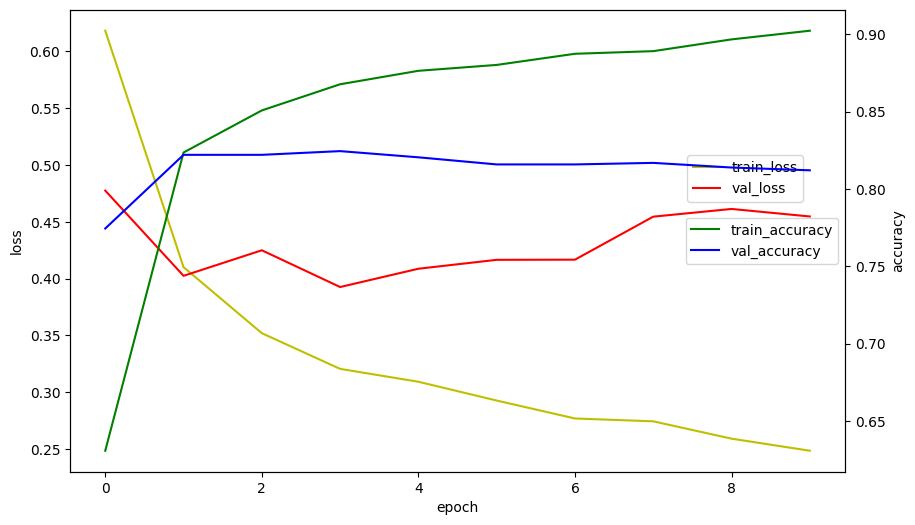

In [116]:
# 학습과정 표시하기
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax 생성
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(bbox_to_anchor=(0.955, 0.7))
acc_ax.legend(loc='center right')
plt.show()

In [117]:
# 테스트 데이터로 평가
loss, acc = model.evaluate(X_test, y_test)
print('test의 데이터 정확도 :', acc)

782/782 [==============================] - 6s 7ms/step - loss: 0.4883 - acc: 0.8020
test의 데이터 정확도 : 0.8020399808883667


In [128]:
# 모델 저장
model.save('imdb_v2.10_skip30length200.h5')

In [118]:
# 혼동행렬(교차표, 평가성능지표)
#y_test # 실제값
pred = model.predict(X_test)
y_hat = (pred>0.5).astype(int) # 예측값
y_hat

782/782 [==============================] - 6s 7ms/step


array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [119]:
y_test.shape, y_hat.shape

((25000,), (25000, 1))

In [120]:
# 실제값(1차원)과 예측값(2차원)의 차원이 같지 않아도 됨
confusion_matrix(y_test, y_hat)

array([[ 9956,  2544],
       [ 2405, 10095]], dtype=int64)

In [121]:
ct = pd.crosstab(y_test, y_hat.reshape(-1))

In [122]:
# 실제값과 예측값의 차원이 1차원
ctab = pd.crosstab(y_test, y_hat.reshape(-1), rownames=['실제값'], colnames=['예측값'])
ctab['0_확률'] = [ctab.loc[0,0]/25000*100, ctab.loc[1,0]/25000*100]
ctab['1_확률'] = [ctab.loc[0,1]/25000*100, ctab.loc[1,1]/25000*100]
ctab

예측값,0,1,0_확률,1_확률
실제값,,,,
0,9956,2544,39.824,10.176
1,2405,10095,9.620,40.380


In [123]:
# accuracy, precision, recall, f1_score
print('acc : ', acc)
print('precision :', precision_score(y_test, y_hat))
print('recall :', recall_score(y_test, y_hat))
print('f1 score :', f1_score(y_test, y_hat))

acc :  0.8020399808883667
precision : 0.798718253026347
recall : 0.8076
f1 score : 0.8031345717808983


# 12. 모델 사용하기

In [124]:
import re
review ="""This movie is highly complete and immersive from start to finish. 
Each role perfectly melts into the character and performs natural and persuasive acts. 
The story is solid and the production is smooth, leading the emotional line to suction. 
The combination of visual beauty and music enhances the overall completeness. 
It is a well-made movie in which all elements shine in harmony. ^_^ -.-  :(
""".lower()
review = re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.split()
print(review)
encoded = [1] + [word_to_id.get(r, -1)+3 for r in review]
encoded = [2 if (e<=20) | (e>1000) else e  for e in encoded] # skip_top 사용시
print(encoded, len(encoded))

['this', 'movie', 'is', 'highly', 'complete', 'and', 'immersive', 'from', 'start', 'to', 'finish', 'each', 'role', 'perfectly', 'melts', 'into', 'the', 'character', 'and', 'performs', 'natural', 'and', 'persuasive', 'acts', 'the', 'story', 'is', 'solid', 'and', 'the', 'production', 'is', 'smooth', 'leading', 'the', 'emotional', 'line', 'to', 'suction', 'the', 'combination', 'of', 'visual', 'beauty', 'and', 'music', 'enhances', 'the', 'overall', 'completeness', 'it', 'is', 'a', 'well', 'made', 'movie', 'in', 'which', 'all', 'elements', 'shine', 'in', 'harmony']
[2, 2, 2, 2, 545, 601, 2, 2, 39, 380, 2, 2, 257, 217, 950, 2, 83, 2, 109, 2, 2, 2, 2, 2, 2, 2, 65, 2, 2, 2, 2, 365, 2, 2, 971, 2, 921, 347, 2, 2, 2, 2, 2, 2, 936, 2, 228, 2, 2, 444, 2, 2, 2, 2, 73, 93, 2, 2, 63, 32, 791, 2, 2, 2] 64


In [125]:
input_data = pad_sequences([encoded],
                       maxlen=MY_LENGTH,
                       truncating='post', # 80단어 이상일 경우 어디를 짜를지 여부
                       #truncating='pre' ,
                       #padding='post',
                       padding='pre' # 길 경우, 뒷부분을 짜르고 짧은 경우 앞에 zero를 붙임
                     )
input_data

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   2,   2,   2,
          2, 545, 601,   2,   2,  39, 380,   2,   2, 257, 217, 950,   2,
         83,   2, 109,   2,   2,   2,   2,   2,   2,   2,  65,   2,   2,
          2,   2, 365,   2,   2, 971,   2, 921, 347,   2,   2,   2,   2,
          2,   2, 936,   2, 228,   2,   2, 444,   2,   2,   2,   2,  73,
         93,   2,   2,  63,  32, 791,   2,   2,   2]])

In [126]:
(model.predict(input_data) > 0.5 ).astype('int8')

1/1 [==============================] - 0s 27ms/step


array([[1]], dtype=int8)

In [127]:
review = """The movie leaves only disappointing elements from the beginning to the end. 
The story is sloppy and the development is distracting, making it impossible to concentrate at all. 
The characters move without depth, and the actors' acting is awkward, 
so the emotional line cannot be conveyed. The direction is too far-fetched, 
and the editing is not smooth, so the flow is constantly cut off.  ^.^
The whole work seems flat because the beauty and music are not impressive. 
It is the worst film with low completeness that makes you feel like you need to watch it until the end."""
review = re.sub('[^a-zA-Z0-9\s]', ' ', review)
review = review.lower().split()
encoded = [1] + [word_to_id.get(r, -1)+3 for r in review]
encoded = [e if (e>=20) & (e<=1000) else 2 for e in encoded]
print(encoded, len(encoded))

[2, 2, 20, 889, 64, 2, 791, 39, 2, 454, 2, 2, 130, 2, 65, 2, 2, 2, 2, 943, 2, 2, 231, 2, 2, 2, 2, 33, 32, 2, 105, 847, 209, 2, 2, 2, 156, 116, 2, 2, 38, 2, 921, 347, 566, 30, 2, 2, 458, 2, 99, 230, 2, 2, 2, 802, 2, 24, 2, 38, 2, 2, 2, 2, 605, 125, 2, 226, 157, 186, 2, 88, 2, 936, 2, 228, 26, 24, 2, 2, 2, 2, 249, 22, 2, 364, 2, 2, 166, 25, 235, 40, 25, 359, 2, 106, 2, 366, 2, 130] 100
